# Voltage‑dependent dose–response analysis
A step‑by‑step notebook that mirrors the procedure used in *Tauber & Ben‑Chaim 2022*.

Fill in your own data (CSV or manual entry) and run each cell one‑by‑one.
Feel free to save this notebook under a new name for your experiments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
plt.rcParams['figure.dpi'] = 120  # sharper plots


## 1  Load or paste your normalised data
Create a CSV with **three columns**:
* `holding` – the holding potential in mV (e.g. -80, -10, +40 …)
* `conc_nM` – concentration in **nM** (numeric)
* `resp` – normalised response (0–1)

Example rows:
```csv
holding,conc_nM,resp
-80,1,0.05
-80,10,0.45
-10,10,0.28
```
If you already have a DataFrame in memory, skip the next cell.

In [6]:
# Replace 'my_data.csv' with your file path
df = pd.read_csv('test_data.csv')
# Uncomment below to preview
# df.head()


In [7]:
df.head()

,holding,conc_nM,resp
0,-80,0,0.0
1,-80,0,0.0
2,-80,0,0.0
3,-80,0,0.0
4,-80,0,0.0


## 2  Define the Hill equation

In [4]:
def hill(x, ec50, nH=1.0, top=1.0, bottom=0.0):
    """Four-parameter logistic with fixed top/bottom."""
    return bottom + (top-bottom) * (x**nH) / (x**nH + ec50**nH)


## 3  Fit each voltage separately

In [9]:
results = {}      # will hold EC50 values keyed by holding potential
rss     = {}      # will hold residual sum-of-squares keyed the same way

for V in df['holding'].unique():     # iterate over each distinct voltage
    x = df.loc[df.holding==V, 'conc_nM'].values   # concentrations for this V
    y = df.loc[df.holding==V, 'resp'].values      # responses   for this V

    # ---- Non-linear least-squares fit ------------------------------
    # • hill(x, ec50) is our model (Hill slope fixed at 1).
    # • lambda x,e: hill(x,e) tells curve_fit “fit ONE parameter = e”.
    # • bounds=(0,∞) constrains EC50 to positive values.
    popt, _ = curve_fit(lambda x,e: hill(x, e), x, y, bounds=(0, np.inf))
    ec50 = popt[0]                    # popt is a 1-element array

    results[V] = ec50                # store EC50 for this voltage

    # ---- Compute residual sum-of-squares ---------------------------
    residuals = y - hill(x, ec50)     # y_i − ŷ_i
    rss[V] = np.sum(residuals**2)     # Σ(residual²)

# Pretty-print what we found
print("Separate-fit EC50 (nM):")
for V, ec in results.items():
    print(f"  {V:+} mV   {ec:.2f}")


Separate-fit EC50 (nM):
  -80 mV   10.14
  -10 mV   37.58


## 4  Extra‑sum‑of‑squares F‑test (are EC₅₀s different?)

In [10]:
# --- Extra-sum-of-squares F-test: are the curves (EC50 values) different? ---

x_all = df['conc_nM'].values
y_all = df['resp'].values

# Fit a single (global) Hill curve — one shared EC50
ec50_global, _ = curve_fit(lambda x, e: hill(x, e), x_all, y_all,
                           bounds=(0, np.inf))
rss_global = np.sum((y_all - hill(x_all, ec50_global))**2)

# Degrees-of-freedom bookkeeping
k_sep = len(results)          # parameters in the separate model (one EC50 per voltage)
k_glob = 1                    # parameters in the global model (shared EC50)
df_num = k_sep - k_glob       # numerator d.f.  = # extra parameters
df_den = len(y_all) - k_sep   # denominator d.f. = N − parameters_separate

# Residual sum-of-squares for the separate fits
RSS_sep = sum(rss.values())

# F statistic
F = ((rss_global - RSS_sep) / df_num) / (RSS_sep / df_den)

# p-value
p = 1 - stats.f.cdf(F, df_num, df_den)

print(f'F = {F:.3f},  p = {p:.4e}')


F = 28.833,  p = 1.0329e-06


## 5  Plot curves + data

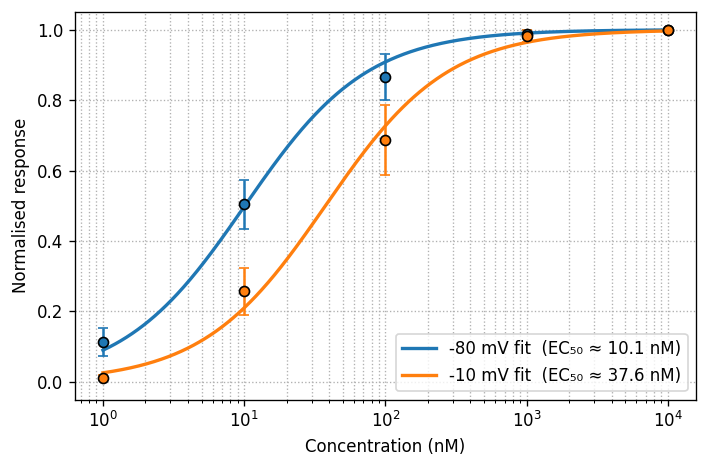

In [ ]:
# ------------------------------------------------------------------
# 1.  Prep (remove the zero-nM rows from the log-scale range)
# ------------------------------------------------------------------
df_nz  = df[df.conc_nM > 0]                     # non-zero concs only
stats_df = (df_nz
            .groupby(['holding','conc_nM'])
            .agg(mean_resp=('resp','mean'),
                 sem_resp =('resp',lambda x: x.std(ddof=1)/np.sqrt(len(x))))
            .reset_index())

# ------------------------------------------------------------------
# 2.  Fit EC50 for each holding potential (to the mean points)
# ------------------------------------------------------------------
EC50 = {}
for V in stats_df.holding.unique():
    sub = stats_df[stats_df.holding == V]
    popt,_ = curve_fit(lambda x,e: hill(x,e), sub.conc_nM, sub.mean_resp,
                       bounds=(0,np.inf))
    EC50[V] = popt[0]

# ------------------------------------------------------------------
# 3.  Plot mean ± SEM + separate fit lines
# ------------------------------------------------------------------
x_min = stats_df.conc_nM.min()
x_max = stats_df.conc_nM.max()
xfit  = np.logspace(np.log10(x_min), np.log10(x_max), 600)

plt.figure(figsize=(6,4))
colour_cycle = plt.cm.tab10.colors     # plenty of distinct colours

for (V,color) in zip(sorted(EC50.keys()), colour_cycle):
    # Smooth fitted curve
    plt.semilogx(xfit, hill(xfit, EC50[V]), color=color, lw=2.0,
                 label=f'{V:+} mV fit  (EC₅₀ ≈ {EC50[V]:.1f} nM)')
    # Mean ± SEM symbols
    sub = stats_df[stats_df.holding == V]
    plt.errorbar(sub.conc_nM, sub.mean_resp, yerr=sub.sem_resp,
                 fmt='o', ms=6, capsize=3, color=color)

plt.xlabel('Concentration (nM)')
plt.ylabel('Normalised response')
plt.ylim(-0.05, 1.05)
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()
